# Kernel $k$-means

In [3]:
from copy import deepcopy
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm
from sklearn.datasets import make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

from kkmeans import rbf_kernel, kkmeans

## Visualizing the space transformation
The Kernel K-means algorithm is an iterative method that clusters data points $x_i \in \Re^n$ into k distinct groups $\pi_k$. This is achieved by implicitly mapping the data points to a higher-dimensional feature space $H$ through a nonlinear transformation $\Phi$ and minimizing the within-cluster scatter.

This implementation chooses the rbf kernel as a default. However, due to the taylor expansion of the exponential function this is equivalent to a dot product in an infinite space. Since the explicit calculation of the transformation $\phi(x)$ is therefore not feasable, we will look at an explicit transofmration $\phi: \Re^2 \mapsto \Re^3$ from the polynomial kernel $K(x,y) = (x^\mathsf{T} y + c)^{d}$.

$\phi(x) = [\sqrt{2}x_1x_2, x_1^2, x_2^2]^\mathsf{T}$

In [4]:
def phi(X):
    return -np.vstack((np.sqrt(2) * X[:,0] * X[:,1], X[:,0]**2, X[:,1]**2)).T

In [5]:
data_set, labels = make_circles(1000, factor=.1, noise=.01, random_state = 0)
transformed = phi(data_set)

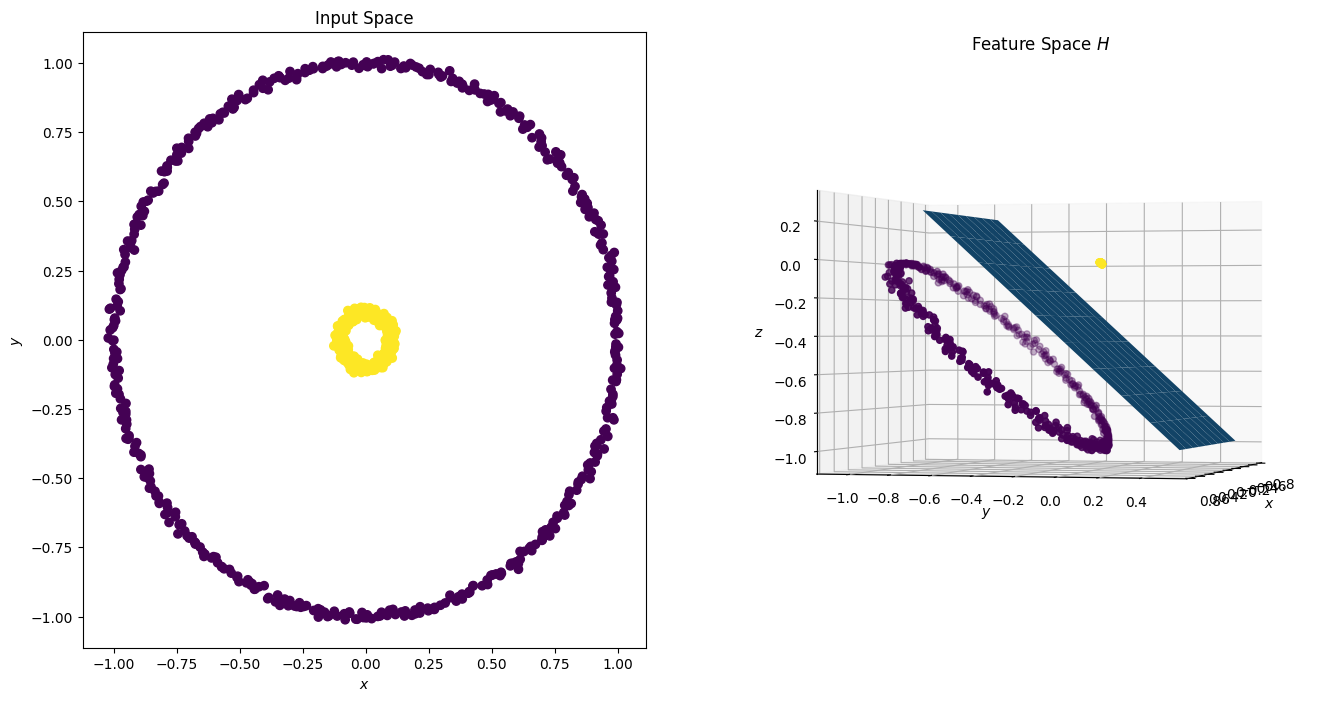

In [6]:
# 2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_set[:,0], data_set[:,1], c=labels, cmap='viridis')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Input Space')

# 3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(transformed[:,0], transformed[:,1], transformed[:,2],c=labels, cmap='viridis')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Feature Space $H$')


clf = svm.SVC(kernel='linear')
clf.fit(transformed, labels)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-.75,.5, 10)
xx,yy = np.meshgrid(tmp,tmp)
ax.plot_surface(xx, yy, z(xx,yy), alpha=1)
ax.view_init(0, 15)


plt.show()

# Benchmarking

## Benchmarking - Datasize

With a fixed amount of clusters and a fixed dimension, run all algorithms for different data set sizes.

In [7]:
def gen_data(n_samples, n_clusters, n_features):
    X, _ = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

In [8]:
def sum_of_variances(X, labels):
    unique_labels = np.unique(labels)
    sum_of_vars = 0
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        var = np.mean(np.sum((cluster_points - centroid) ** 2, axis=1))
        sum_of_vars += var
    return sum_of_vars


In [9]:
n_clusters = 5
n_features = 3

x = np.array([1e2, 1e3, 1e4, 5e4, 1e5, 5e5, 1e6])
x = np.int_(x)
len_x = len(x)

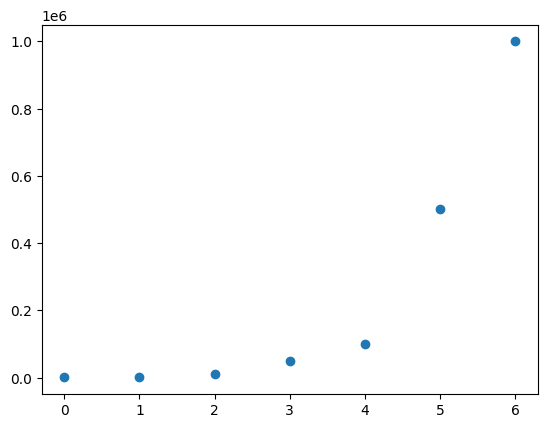

In [10]:
plt.scatter(np.arange(0,len_x), x)
plt.show()

In [ ]:
clustering_results = {'dbscan': [], 'agglo': [], 'spectral': [], 'gmm': [], 'kkmeans': []}
data_sets = []

for i, n_samples in enumerate(x):
    print(f"Iter {i} of {len_x}")
    data = gen_data(n_samples, n_clusters, n_features)
    data_sets.append(data)
    
    
    algo_map = [
        ('dbscan', DBSCAN(eps=0.5, min_samples=n_clusters)),
        ('agglo', AgglomerativeClustering(n_clusters=n_clusters)),
        ('spectral', SpectralClustering(n_clusters=n_clusters)),
        ('gmm', GaussianMixture(n_components=n_clusters)),
        ('kkmeans', kkmeans(data, n_clusters=n_clusters))
    ]
    
    for algo_name, algo in algo_map:
        if algo_name == 'kkmeans':
            labels = algo
        else:
            algo.fit(data)
            labels = algo.labels_ if hasattr(algo, 'labels_') else algo.predict(data)
        clustering_results[algo_name].append(labels)

print(f"{len_x} runs complete.")

Iter 0 of 7
Iter 1 of 7
Iter 2 of 7
Iter 3 of 7


In [1]:
scores_dict = {'silhouette': [], 'calinski': [], 'davies': [], 'sum_of_vars': []}
scores_result = {
    'dbscan': deepcopy(scores_dict),
    'agglo': deepcopy(scores_dict),
    'spectral': deepcopy(scores_dict),
    'gmm': deepcopy(scores_dict),
    'kkmeans': deepcopy(scores_dict)
}
 
for algo_name in clustering_results:
    for i, labels in enumerate(clustering_results[algo_name]):
        data_set = data_sets[i]
        if len(np.unique(labels)) <= 1:
            print(f"Cannot compute scores for algo {algo_name} with only one cluster.")
            silhouette = np.nan
            calinski = np.nan
            davies = np.nan
            sum_of_vars = np.nan
        else:
            silhouette = silhouette_score(data_set, labels)
            calinski = calinski_harabasz_score(data_set, labels)
            davies = davies_bouldin_score(data_set, labels)
            sum_of_vars = np.nan if name == "dbscan" else sum_of_variances(data_set, labels)   
        
        scores_map = [
            ('silhouette', silhouette),
            ('calinski', calinski),
            ('davies', davies),
            ('sum_of_vars', sum_of_vars)
        ]
        
        for score_name, score in scores_map:  
            scores_result[algo_name][score_name].append(score)

NameError: name 'deepcopy' is not defined

In [188]:
print(len(scores_result['spectral']['sum_of_vars']))

12


12000


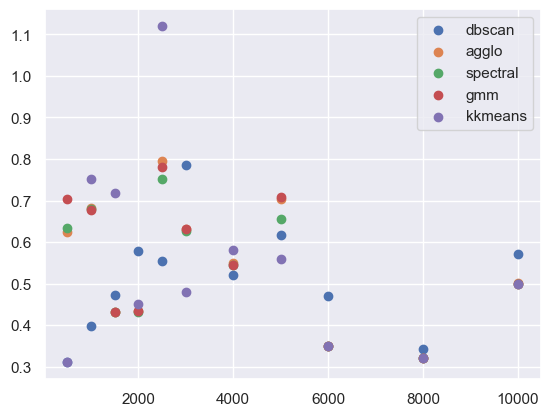

In [195]:
for algo in ['dbscan', 'agglo', 'spectral', 'gmm', 'kkmeans']:
    x_new = x[:11]
    y = scores_result[algo]['davies'][:11]
    a, b = np.polyfit(x_new, y, 1)

    plt.scatter(x_new, y, label=algo)
    
    # plt.plot(x_new, a*x_new+b, label=algo)  


plt.legend()
# print(a) # 6.022320344697754

print(x[11])

## Benchmarking - Dimensions

With a fixed amount of clusters and a fixed amount of data points, run all algorithms on different dimensions.

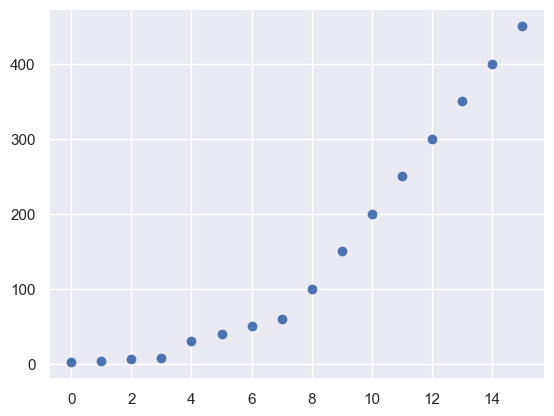

In [239]:
n_clusters = 5
n_samples = 500

x = np.hstack([np.arange(1, 5)*2, np.arange(3, 7) * 10, np.arange(2, 10) * 50])
len_x = len(x)
plt.scatter(np.arange(0,len_x), x)
plt.show()

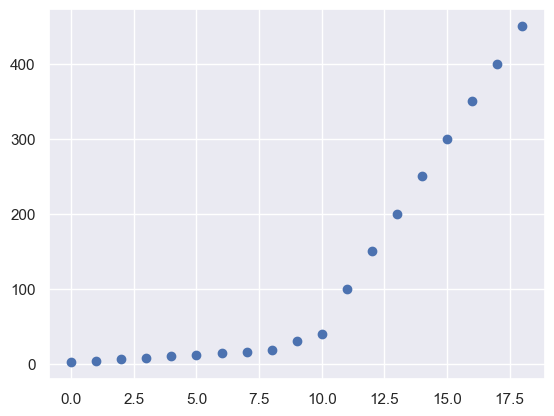

In [196]:
clustering_results = {'dbscan': [], 'agglo': [], 'spectral': [], 'gmm': [], 'kkmeans': []}
data_sets = []

for i, n_features in enumerate(x):
    print(f"Iter {i} of {len_x}") if i % 5 == 0 else ""
    data = gen_data(n_samples, n_clusters, n_features)
    data_sets.append(data)
    
    
    algo_map = [
        ('dbscan', DBSCAN(eps=0.5, min_samples=n_clusters)),
        ('agglo', AgglomerativeClustering(n_clusters=n_clusters)),
        ('spectral', SpectralClustering(n_clusters=n_clusters)),
        ('gmm', GaussianMixture(n_components=n_clusters)),
        ('kkmeans', kkmeans(data, n_clusters=n_clusters))
    ]
    
    for algo_name, algo in algo_map:
        if algo_name == 'kkmeans':
            labels = algo
        else:
            algo.fit(data)
            labels = algo.labels_ if hasattr(algo, 'labels_') else algo.predict(data)
        clustering_results[algo_name].append(labels)

print(f"{len_x} runs complete.")

Iter 0 of 61
Iter 5 of 61
Iter 10 of 61
Iter 15 of 61
Iter 20 of 61
Iter 25 of 61


KeyboardInterrupt: 

In [197]:
scores_dict = {'silhouette': [], 'calinski': [], 'davies': [], 'sum_of_vars': []}
scores_result = {
    'dbscan': deepcopy(scores_dict),
    'agglo': deepcopy(scores_dict),
    'spectral': deepcopy(scores_dict),
    'gmm': deepcopy(scores_dict),
    'kkmeans': deepcopy(scores_dict)
}

for algo_name in clustering_results:
    for i, labels in enumerate(clustering_results[algo_name]):
        data_set = data_sets[i]
        if len(np.unique(labels)) <= 1:
            print(f"Cannot compute scores for algo {algo_name} with only one cluster.")
            silhouette = np.nan
            calinski = np.nan
            davies = np.nan
            sum_of_vars = np.nan
        else:
            silhouette = silhouette_score(data_set, labels)
            calinski = calinski_harabasz_score(data_set, labels)
            davies = davies_bouldin_score(data_set, labels)
            sum_of_vars = np.nan if name == "dbscan" else sum_of_variances(data_set, labels)   
        
        scores_map = [
            ('silhouette', silhouette),
            ('calinski', calinski),
            ('davies', davies),
            ('sum_of_vars', sum_of_vars)
        ]
        
        for score_name, score in scores_map:  
            scores_result[algo_name][score_name].append(score)

Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores for algo dbscan with only one cluster.
Cannot compute scores fo

In [198]:
print(len(scores_result['spectral']['sum_of_vars']))

30


In [230]:
for algo in ['dbscan', 'agglo', 'spectral', 'gmm', 'kkmeans']:
    x_new = x[:29]
    y = scores_result[algo]['calinski'][:29]
    a, b = np.polyfit(x_new, y, 1)

    plt.plot(x_new, y, label=algo)
    
    # plt.plot(x_new, a*x_new+b, label=algo)  


plt.legend()
# print(a) # 6.022320344697754

print(x[11])

TypeError: expected x and y to have same length